In [1]:
from uproot_io import Events, View
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
#titlesize = 20
#labelsize = 14
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [2]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [131]:
testing = np.load("testing_events.npy")
truth = np.load("truth_data.npy")
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [45]:
def biggest():
    biggest = []
    eventlabel = []
    tslabel = []
    biggest = []
    party = []
    idexz = []
    
    for n in testing:
        nhits = 0
        big = []
        idx = np.where(events.event_number == n)[0]
        
        for i in idx:
            x = events.reco_hits_x_w[i]
            z = events.reco_hits_w[i]
            pdg = events.mc_pdg[i]
            purity = events.purity[i]
            complete = events.completeness[i]
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                idexz.append(i)
                if len(x) > nhits:
                    nhits = len(x)
                    big.append(i)
        
        if len(big) != 0:
            biggest.append(big[-1])

            x = events.reco_hits_x_w[big[-1]]
            z = events.reco_hits_w[big[-1]]
            pdg = events.mc_pdg[big[-1]]
            purity = events.purity[big[-1]]
            complete = events.completeness[big[-1]]

            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:    
                party.append(pdg)
                if pdg == 22. or pdg == -11. or pdg == 11.:
                    tslabel.append(0) #showers
                else:
                    tslabel.append(1) #tracks
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                if truth[n] == 0:
                    eventlabel.append(0) #muon
                if truth[n] == 1:
                    eventlabel.append(1) #electron
                if truth[n] == 2:
                    eventlabel.append(2) #nc
    
    return biggest, eventlabel, tslabel, party, idexz

In [46]:
big, eventlabel, tslabel, particle, idexz = biggest()

In [85]:
big = np.array(big)
eventlabel = np.array(eventlabel)
idexz = np.array(idexz)
keep = np.where(eventlabel != 2)
bigcut = big[keep]

In [86]:
common_elements1 = np.intersect1d(idexz, big)
allindices = np.flatnonzero(np.isin(idexz, common_elements1))
common_elements2 = np.intersect1d(idexz, bigcut)
cutindices = np.flatnonzero(np.isin(idexz, common_elements2))

In [132]:
x_test = x_test[allindices]
y_test = y_test[allindices]

In [133]:
np.shape(x_test)

(2729, 5)

In [4]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=14)
bdt = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdt.fit(x_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14),
                   n_estimators=100, random_state=0)

In [5]:
# Check the training set classification performance
bdt.score(x_train, y_train)

1.0

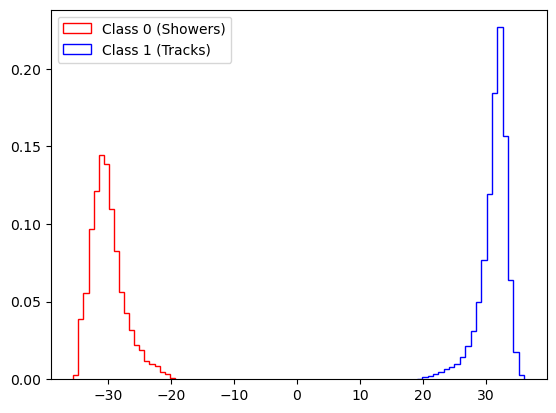

In [6]:
f0 = bdt.decision_function(x_train)
min_f = np.round(np.min(f0), 1)
max_f = np.round(np.max(f0), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f0 = f0[np.where(y_train == 0)]
cls_1_f0 = f0[np.where(y_train == 1)]
weights_0 = np.ones_like(cls_0_f0) / len(cls_0_f0)
weights_1 = np.ones_like(cls_1_f0) / len(cls_1_f0)
plt.hist(cls_0_f0, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Showers)')
plt.hist(cls_1_f0, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Tracks)')
plt.legend()

In [134]:
# Check the test set classification performance
bdt.score(x_test, y_test)

0.9930377427629168

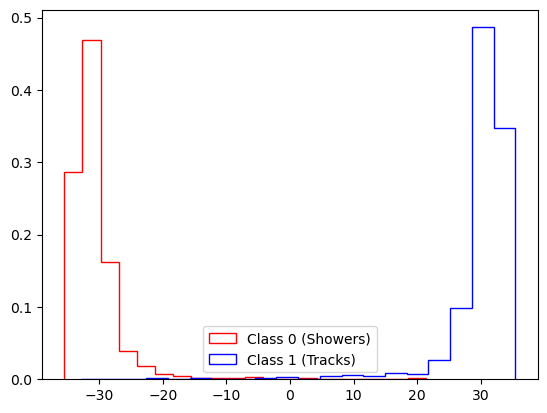

In [135]:
f = bdt.decision_function(x_test)
min_f = np.round(np.min(f), 1)
max_f = np.round(np.max(f), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f = f[np.where(y_test == 0)]
cls_1_f = f[np.where(y_test == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Showers)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Tracks)')
plt.legend()

In [136]:
print(min(cls_0_f)), print(max(cls_1_f))

-35.487770622752855
35.43387184223213


(None, None)

In [137]:
#indexx = np.where(eventlabel != 2)
#cutevents = eventlabel[indexx]

muons = f[np.where(eventlabel == 0)]
electrons = f[np.where(eventlabel == 1)]
nc = f[np.where(eventlabel == 2)]
len(muons), len(electrons), len(nc)

(1033, 1110, 586)

In [138]:
goodmu = []
badmu = []
goode = []
bade = []

for n in muons:
    if n >= -8.5:
        goodmu.append(n)
    else:
        badmu.append(n)
for k in electrons:
    if k >= -8.5:
        bade.append(k)
    else:
        goode.append(k)

In [139]:
TMAM = len(goodmu)/(len(goodmu)+len(badmu))
TMAE = len(badmu)/(len(goodmu)+len(badmu))
TEAM = len(bade)/(len(goode)+len(bade))
TEAE = len(goode)/(len(goode)+len(bade))

confusion = np.array(([TMAM, TMAE],[TEAM, TEAE]))
print(confusion)

e1 = np.sqrt((TMAM*(1-TMAM))/len(goodmu))
e2 = np.sqrt((TMAE*(1-TMAE))/len(badmu))
e3 = np.sqrt((TEAM*(1-TEAM))/len(bade))
e4 = np.sqrt((TEAE*(1-TEAE))/len(goode))

error = np.array(([e1, e2],[e3, e4]))
print(error)

[[0.91190707 0.08809293]
 [0.07027027 0.92972973]]
[[0.00923465 0.02971154]
 [0.02894122 0.00795654]]


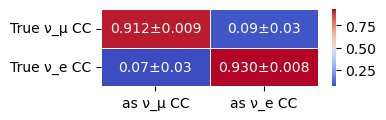

In [130]:
import seaborn as sns
variable_names1 = ['as ν_μ CC', 'as ν_e CC']
variable_names2 = ['True ν_μ CC', 'True ν_e CC']

annot_arr = np.array([['0.912±0.009','0.09±0.03'],
                      ['0.07±0.03','0.930±0.008']], dtype = str)

plt.figure(figsize = (3.5,1))
heatmap = sns.heatmap(confusion, annot=annot_arr, cmap='coolwarm', fmt="s", linewidths=.5, square=False)
heatmap.set_xticklabels(variable_names1, rotation=0)
heatmap.set_yticklabels(variable_names2, rotation=0)
#plt.title("Confusion Matrix")±±±±±
plt.show()

In [147]:
predictions = []
for n, i in enumerate(f):
    if i >= -3.5:
        #track
        if particle[n] == 13. or particle[n] == -13.:
            predictions.append(0)
        else:
            predictions.append(2)
    if i < -3.5:
        #shower
        if particle[n] == 11. or particle[n] == -11.:
            predictions.append(1)
        else:
            predictions.append(2)        

In [148]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(eventlabel, predictions)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

In [149]:
conf_matrix_decimals

array([[0.82478219, 0.00484027, 0.17037754],
       [0.0027027 , 0.86036036, 0.13693694],
       [0.01194539, 0.01877133, 0.96928328]])

Text(50.722222222222214, 0.5, 'True Label')

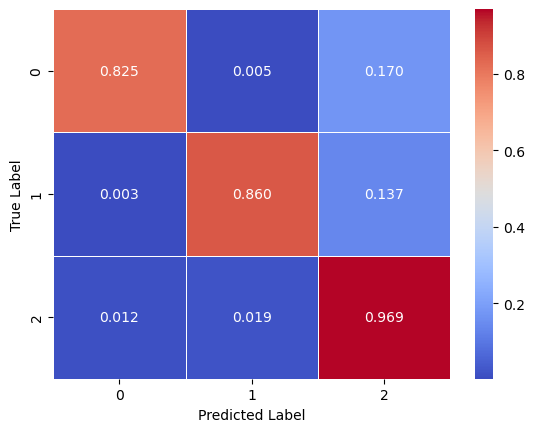

In [150]:
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [141]:
TIT = cls_1_f
SIT = cls_0_f

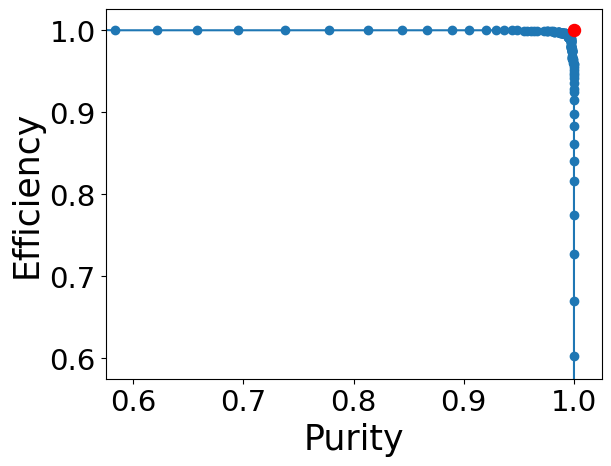

Best cut: -3.5
At distance: 0.0085518816319566
With AUC: 0.9995047227716957


In [142]:
cuts = np.arange(-35, 35, 0.5)
efficiency = []
purity = []

purity.append(0)
efficiency.append(1)

for i in cuts:
    goodtrk = []
    badtrk = []
    goodshw = []
    badshw = []
    for n in TIT:
        if n >= i:
            goodtrk.append(n)
        else:
            badtrk.append(n)
    for k in SIT:
        if k >= i:
            badshw.append(k)
        else:
            goodshw.append(k)

    eff = len(goodtrk)/(len(TIT))
    pur = len(goodtrk)/(len(goodtrk)+len(badshw))

    efficiency.append(eff)
    purity.append(pur)

purity.append(1)
efficiency.append(0)

plt.scatter(purity, efficiency)
plt.plot(purity, efficiency)
plt.scatter(1, 1, s=75, c='r')
plt.xlim(0.6,1.025)
#plt.ylim(0.6,1.025)
plt.xlabel('Purity', fontsize=25)
plt.ylabel('Efficiency', fontsize=25)
#plt.title('ROC Curve for Track Likelihood')
plt.xticks(np.arange(0.6, 1.1, step=0.1), fontsize = 21)
plt.yticks(np.arange(0.6, 1.1, step=0.1), fontsize = 21)
plt.xlim(0.575,1.025)
plt.ylim(0.575,1.025)
plt.show()

np.save("CE_BDT", efficiency)
np.save("CP_BDT", purity)

area = np.trapz(efficiency, x=purity)

point = np.array([1, 1])
data_points = np.column_stack((purity, efficiency))
distances = np.linalg.norm(data_points - point, axis=1)
closest_index = np.argmin(distances)
closest_point = data_points[closest_index]
dist = distances[closest_index]
cutpoint = cuts[closest_index]

print('Best cut:', cutpoint)
print('At distance:', dist)
print('With AUC:', area)

#efficiency (true tracks as tracks/total true tracks)
#purity (true tracks as tracks/number we have called tracks)

In [16]:
TTAT = []
TTAS = []
TSAT = []
TSAS = []

for i, n in enumerate(TIT):
    if n >= cutpoint:
        TTAT.append(n)
        leng1.append(trkleng[i])
        part1.append(trkpart[i])
    if n < cutpoint:
        TTAS.append(n)
        leng2.append(trkleng[i])
        part2.append(trkpart[i])
        
for i, k in enumerate(SIT):
    if k >= cutpoint:
        TSAT.append(k)
        leng3.append(shwleng[i])
        part3.append(shwpart[i])
    if k < cutpoint:
        TSAS.append(k)
        leng4.append(shwleng[i])
        part4.append(shwpart[i])

TTATprob = len(TTAT)/(len(TTAT)+len(TTAS))
TTASprob = len(TTAS)/(len(TTAT)+len(TTAS))
TSATprob = len(TSAT)/(len(TSAT)+len(TSAS))
TSASprob = len(TSAS)/(len(TSAT)+len(TSAS))

confusion = np.array(([TTATprob, TTASprob],[TSATprob, TSASprob]))
print(confusion)

e1 = np.sqrt((TTATprob*(1-TTATprob))/len(TTAT))
e2 = np.sqrt((TTASprob*(1-TTASprob))/len(TTAS))
e3 = np.sqrt((TSATprob*(1-TSATprob))/len(TSAT))
e4 = np.sqrt((TSASprob*(1-TSASprob))/len(TSAS))

error = np.array(([e1, e2],[e3, e4]))
print(error)

[[0.9797681  0.0202319 ]
 [0.02833265 0.97166735]]
[[0.00154717 0.01076668]
 [0.01407327 0.00240314]]


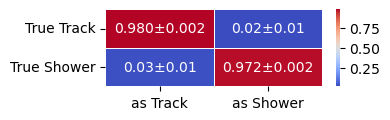

In [17]:
import seaborn as sns
variable_names1 = ['as Track', 'as Shower']
variable_names2 = ['True Track', 'True Shower']

annot_arr = np.array([['0.980±0.002','0.02±0.01'],
                      ['0.03±0.01','0.972±0.002']], dtype = str)

plt.figure(figsize = (3.5,1))
heatmap = sns.heatmap(confusion, annot=annot_arr, cmap='coolwarm', fmt="s", linewidths=.5, square=False)
heatmap.set_xticklabels(variable_names1, rotation=0)
heatmap.set_yticklabels(variable_names2, rotation=0)
#plt.title("Confusion Matrix")±±±±±
plt.show()

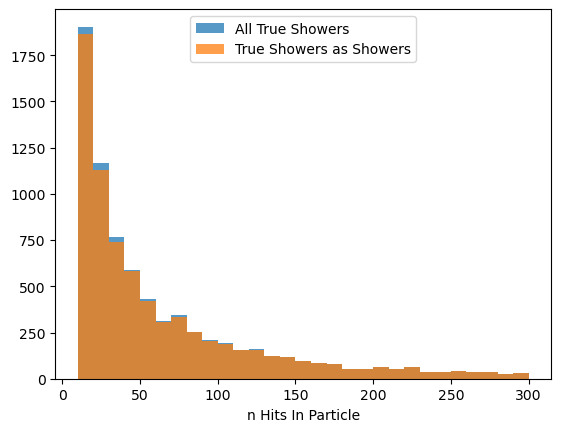

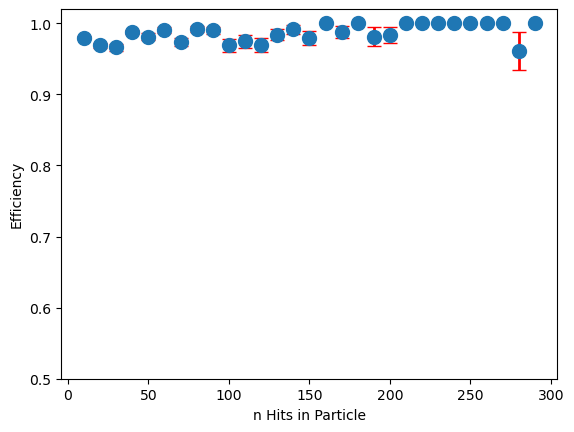

In [20]:
#print(max(trkleng))
#print(max(shwleng))
bin_edges = np.arange(10, 310, 10)

hist1, _ = np.histogram(trkleng, bins=bin_edges)
hist2, _ = np.histogram(leng1, bins=bin_edges)

#hist1_normalized = hist1 / len(trkleng)
#hist2_normalized = hist2 / len(leng1)

plt.bar(bin_edges[:-1], hist1, width=10, align='edge', alpha=0.75, label='All True Showers')
plt.bar(bin_edges[:-1], hist2, width=10, align='edge', alpha=0.75, label='True Showers as Showers')
#plt.title('')
plt.xlabel('n Hits In Particle')
plt.legend(loc='upper center')
plt.show()

xvalues = np.arange(10, 300, 10)
eff = hist2/hist1
error = []

for i, val in enumerate(eff):
    err = np.sqrt((val*(1-val))/(hist1[i]+hist2[i]))
    error.append(err)

#print(xvalues)
#print(eff)
#print(error)

plt.errorbar(xvalues, eff, yerr=error, fmt='o', elinewidth=2, ecolor='red', capsize=5, ms=10)
#plt.scatter(xvalues, (hist2/hist1))
plt.xlabel('n Hits in Particle')
plt.ylabel('Efficiency')
#plt.xticks(fontsize = 21)
#plt.yticks(fontsize = 21)
plt.ylim(0.5,1.02)
plt.show()